# Project: Machine Learning for Finance
### Felipe MONTENEGRO & Peixin MAO

! pip install jyquickhelper

In [22]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }
  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

## Summary

This project is aim at proposing and comparing efficiency of several methods ,especially including Monte Carlo simulation and machine learning approach, when predicting final value of portfolios. In this project, we use the examples of option value and health insurance fund value. 

Specially, this project have proposed several methods for generating the features map. The first classic full polynomial basis suffers from the explosion of dimensionality while the linear dimensionality reduction based on the first improve the efficiency of features.Besides, the shallow neural network generate the features map directely from initial variables without generating full polynomial basis.Shallow neural network form the features map directely by defining the weight matrices and bias vectors. All of the three methods will than optimize the parametrics of the features to minimize the error when predicting the final value.

## Introduction

This Jupyter Notebook refers to the paper **"A machine learning approach to portfolio pricing and risk
management for high-dimensional problems"**. The paper was written by Lucio Fernandez-Arjona and Damir Filipovic.

The authors propose an alternative approach to estimate conditional expectations across a time interval using Machine Learning approaches to learn a suitable function from finite samples. 

The proposed method is called **Replicating Martingale Method**.

## 1. Importing Libraries

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import itertools
import math
from sklearn.linear_model import LinearRegression

## 2. Pre-requisites

In the paper, the authors test their method with a numerical example in the finance field. Indeed, they calculate the Present Value ($V_0$) and the expected shortfall of $-\Delta V_1$ for a European Call on an Equity Index.

To calculate those metrics, the function `calc_stats` below can be used to derive the **present value (pv)**, **expected shortfal (es)**, and **value-at-risk (var)** of empirical distributions.

In [3]:
# function to calculate Expected Shortfall
# this function is called in the main function (calc_stats)
def es_cal(vec: np.ndarray, *, nalpha: int=None, alpha: float=None)->np.ndarray:
    assert (nalpha is None) != (alpha is None)
    if nalpha is None:
        nalpha = int(len(vec) * alpha)
    ord_vec = np.sort(vec, axis=0)
    d_es = ord_vec[:nalpha].mean()
    u_es = ord_vec[-nalpha:].mean() 
    return np.array([u_es, d_es])


def calc_stats(data):
    mean = data['V'].mean()
    es = es_cal(data['V'].values-mean, alpha=0.01)
    var = np.percentile(data['V'].values-mean, q=[99., 1.])
    return pd.Series(np.array([es[0], es[1], var[0], var[1], mean]), 
                     index=['upper_es (99%)', 'lower_es (1%)', 'upper_var (99%)', 'lower_var (1%)', 'pv (mean)'])

## 3. Numerical Example: European Call on the Equity Index

As mentioned above, our goal will be to calculate the Present Value ($V_0$) and the expected shortfall of $-\Delta V_1$ for a European Call on an Equity Index in two scenarios:

- **5-year maturity European Call ($T=5$), strike $K=100$**
- **40-year maturity European Call ($T=40$), strike $K=100$**

One possible interpretation of the problem is that we hold a short position in one of those calls in our portfolio and therefore focus on the loss-making tail, that is, the tail where the equity index values are higher.

Moreover, the authors create an economic scenario generator that maps a 3-dimensional stochastic drive process $\vec X_t = (X_{1,t}, X_{2,t}, X_{3,t})$ to a vector of economic factors. The most important economic factors of this vector are the Equity Index ($EQ_t$) and the Cash Account ($C_t$).

In this context, considering the European Call payoff at a maturity $T$ of strike $K$, we have that the terminal value function of our portfolio is given by:

$$ f(\vec X) \ = \ \frac{-max(EQ_t-K, 0)}{C_t} $$

As we will see in the section _Train and Validation Data_ section, the variables $EQ_t$ and $C_t$ depend on the value of the vector $\vec X$.

Finally, our goal is to find the value process of the portfolio, which will be referred to as _Present Value_ ($V_0$). This variable will be given by:

$$ V_0 \ = \ \mathbb{E}^{\mathbb{Q}}[f(\vec X)] $$

For the complete theoretical math description of the problem, we invite you to check the _Annex 1: Math Problem Description_.

### 3.1. Input Data

The authors published the datasets used in the numerical examples of the paper. These datasets can be downloaded through this <a href="https://zenodo.org/record/3837381#.YkMSkYVBw2w">link</a>.

There are three categories of datasets that will be of our interest:

1. **Test Data (Benchmark Data):** 
 <font color='red'> Benchmark values: large Monte Carlo simulation</font> 

    - 5-year Europen Call: `call_annual_5y_HW_1million_z1dist.csv`
    - 40-year European Call:`call_annual_40y_HW_1million_z1dist.csv`
    

2. **Train Input Data:**
 <font color='red'> Out-of-sample testing</font> 
 
    - 5-year Europen Call: `call_annual_5y_HW_1million_outer_x.csv`
    - 40-year European Call: `call_annual_40y_HW_1million_outer_x.csv`
    

3. **Train and Validation Data:**
    - 5-year Europen Call: `call_annual_5y_HW_training_data.h5`
    - 40-year European Call: `call_annual_40y_HW_training_data.h5`
    
        

#### Test Data (Benchmark Data)

There are two files containing the distribution of the Monte Carlo estimation of the time-1 value of the European call $E_1[V]=V_1$. Each file contains 1 million simulations of $V_1$.

The files are called `call_annual_5y_HW_1million_z1dist.csv` and `call_annual_40y_HW_1million_z1dist.csv`. They have one column `id` for the simulation id, and one column `V` for $\hat{V}_1$.

This files have been used as an **out-of-sample test of the quality of risk estimates** for the methods described in the paper.

In [4]:
import  os
print(os.getcwd()) #obtenir le chemin de travail

path = os.getcwd()

E:\ENSAE\2021-2022 3A Actuariat\S2\Optionnel\Machine learning for finance\Projet\ML_for_Finance_Project


##### 5-year European call

In [6]:
test_data_5y = pd.read_csv(path+'/data/call_annual_5y_HW_1million_z1dist.csv')
test_data_5y.columns = ['id', 'V']
test_data_5y = test_data_5y.set_index('id')

In [7]:
test_data_5y.head(3)

,V
id,
0,49.172710
1,21.375768
2,45.087081


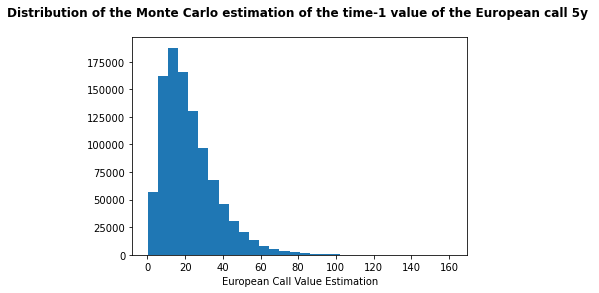



count    1000000.0000
mean          22.1691
std           14.2492
min            0.0677
1%             2.5938
50%           19.0933
99%           68.1120
max          161.5683
Name: V, dtype: float64



upper_es (99%)     56.86
lower_es (1%)     -20.30
upper_var (99%)    45.94
lower_var (1%)    -19.58
pv (mean)          22.17
dtype: float64


In [8]:
n, bins, patches = plt.hist(test_data_5y["V"], bins = 30)
  
plt.xlabel('European Call Value Estimation')
plt.title('Distribution of the Monte Carlo estimation of the time-1 value of the European call 5y \n',
          fontweight ="bold")
plt.show()
print("\n")
print(test_data_5y["V"].describe(percentiles=[.01, .99]).round(4))
print("\n\n")
print(calc_stats(test_data_5y).round(2))

##### 40-year European call

In [9]:
test_data_40y = pd.read_csv(path+'/data/call_annual_40y_HW_1million_z1dist.csv')
test_data_40y.columns = ['id', 'V']
test_data_40y = test_data_40y.set_index('id')

In [10]:
test_data_40y.head(3)

,V
id,
0,55.902387
1,57.857223
2,79.726821


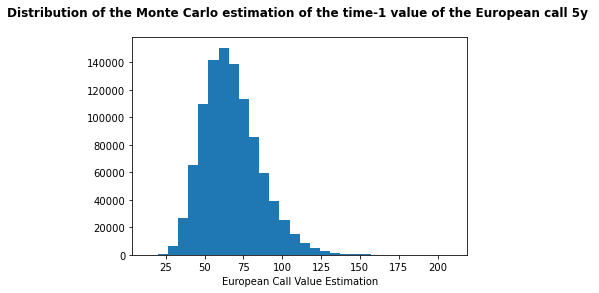



count    1000000.00
mean          67.55
std           18.27
min           13.32
1%            34.05
50%           65.50
99%          119.39
max          209.24
Name: V, dtype: float64



upper_es (99%)     62.62
lower_es (1%)     -36.64
upper_var (99%)    51.84
lower_var (1%)    -33.50
pv (mean)          67.55
dtype: float64


In [11]:
n, bins, patches = plt.hist(test_data_40y["V"], bins = 30)
  
plt.xlabel('European Call Value Estimation')
plt.title('Distribution of the Monte Carlo estimation of the time-1 value of the European call 5y \n',
          fontweight ="bold")
plt.show()
print("\n")
print(test_data_40y["V"].describe(percentiles=[.01, .99]).round(2))
print("\n\n")
print(calc_stats(test_data_40y).round(2))

#### Train Input Data

In order to compare against the `V` values in the test data, it is necessary to use the `X` values contained in the files `call_annual_5y_HW_1million_outer_x.csv` and `call_annual_40y_HW_1million_outer_x.csv`. 

These files contain the simulated values of the independent random variable `X` (3 dimensional) for time-1.

##### 5-year European call

In [12]:
train_inputs_5y = pd.read_csv(path+'/data/call_annual_5y_HW_1million_outer_x.csv')
train_inputs_5y.columns = ['id', 'X_1', 'X_2', 'X_3']
train_inputs_5y = train_inputs_5y.set_index('id')
train_inputs_5y.head(3)

,X_1,X_2,X_3
id,,,
0,-0.778494,-0.191097,1.866854
1,-0.187797,-1.116563,0.228727
2,-1.299981,1.614254,1.800982


##### 40-year European call

In [13]:
train_inputs_40y = pd.read_csv(path+'/data/call_annual_40y_HW_1million_outer_x.csv')
train_inputs_40y.columns = ['id', 'X_1', 'X_2', 'X_3']
train_inputs_40y = train_inputs_40y.set_index('id')
train_inputs_40y.head(3)

,X_1,X_2,X_3
id,,,
0,-0.162761,0.400169,-0.592535
1,-1.386972,1.108603,-0.163673
2,0.017901,-0.082510,0.774258


#### Train and Validation Data

The files `call_annual_5y_HW_training_data.h5` and `call_annual_40y_HW_training_data.h5` contain the datasets with training and validation data. Each file contains 500,000 data points (full path simulations). 

Those datasets are the most important for us and their variables deserve a deep understanding.

They contain:
- **Stochastic Drivers random numbers (`ind_Z` variables)**


- **the economic variable `r` (Hull-White instantaneous rate)**: The interest rate model is based on the continuous time Hull-White short rate model:

    $$ dr_t \ = \ \kappa (b(t) - r_t)dt \ + \ \sigma dW_t $$

In discrete time, we simulate the _short rate_ ($r_t$) jointly from the above Hull-White model, which is based on a one-dimensional Gaussian stochastic driver. We therefore use the first component of $\vec X_t = (X_{1,t}, X_{2,t}, X_{3,t})$. Indeed:

$$ \sigma_r \ = \ \frac{\sigma^2}{2\kappa}(1 \ - \ e^{-2\kappa})  \ \ \text{ ;} $$

$$ g(t) \ = \ \int_t^{t+1} e^{-\kappa (t+1-s)}b(s)ds $$

$${\color{red}{ r_{t+1} \ = \ e^{-\kappa}r_t \ + \ \kappa g(t) \ + \ \sigma_r X_{1,t+1}}} \tag{1}\label{InterestRate} $$

- **the economic variable `cash` (cash account)**: the _log-cash account_ ($Y_t$) is also simulated jointly from the above Hull-White model, but it is based on a two-dimensional Gaussian stochastic driver. We therefore use the first two components of $\vec X_t = (X_{1,t}, X_{2,t}, X_{3,t})$. Indeed:

$$ h(t) \ = \ h(t, t+1) \ = \ \int_t^{t+1} \int_t^u e^{-\kappa(u-s)}b(s)dsdu  \ \ \text{ ;} $$

$$ \sigma_{Y} \ = \ \frac{\sigma^2}{\kappa^2}\left(1 \ + \ \frac{1}{2\kappa}(1 \ - \ e^{-2\kappa}) \ + \ \frac{2}{\kappa}(e^{-\kappa} \ - \ 1) \right)   \ \ \text{ ;} $$

$$ \sigma_{rY} \ = \ \frac{\sigma^2}{2\kappa}\left(1 \ + \ e^{-2\kappa} \ - \ 2e^{-\kappa}\right)   \ \ \text{ ;} $$

$$ \rho_{rY} \ = \ \frac{\sigma_{rY}}{(\sigma_{r}\sigma_{Y})}   \ \ \text{ ;} $$

$$ X^{'}_{2, t+1} \ = \ \rho_{rY} X_{1, t+1} \ + \ \sqrt{1 \ - \ \rho_{rY}^{2}} X_{2, t+1}  $$

$${\color{red}{ Y_{t+1} \ = \ Y_t \ + \ \frac{1}{\kappa}(1 \ - \ e^{-\kappa})r_t \ + \ \kappa h(t) \ + \ \sigma_{Y} X^{'}_{2, t+1}}}$$

And, finally, the variable **`Cash Account`** is given by:

$${\color{red}{C_t \ = \ exp(Y_t)}} \tag{2}\label{CashAccount}$$

- **the economic variable `EQ` (equity index)**: For the equity index, a geometric Brownian process models the respective index excess return, with the recursive formula:

$$ S_{t} \ = \ S_{t-1} \exp\left(-\frac{\sigma^2_3}{2} \ + \ \sigma_3 X^{'}_{3,t}\right) $$

$$ {\color{red}{ EQ_t \ = \ C_t S_t}} \tag{3}\label{EquityIndex}$$

##### 5-year European call

In [14]:
train_data_5y = pd.read_hdf(path+'/data/call_annual_5y_HW_training_data.h5')
train_data_5y = train_data_5y[["ind_Z_0", "ind_Z_1", "ind_Z_2", "cash_0", "r_0", "S_0"]]
pd.set_option('display.max_columns', None)
train_data_5y.head(3)

variable_name   ind_Z_0                                           ind_Z_1  \
time                  1         2         3         4         5         1   
simulation                                                                  
0             -0.282880 -0.280114 -1.737776 -1.250346 -0.527155  0.499004   
1             -0.448382  0.108609 -0.534241  0.614058 -0.818455 -1.521676   
2              0.782956 -0.381633 -1.394899  0.140296 -0.340791 -0.827774   

variable_name                                           ind_Z_2            \
time                  2         3         4         5         1         2   
simulation                                                                  
0              1.419073  1.100434  0.089398  1.352286  0.544870  0.497429   
1             -0.764738 -2.140202 -2.239580 -0.905896 -0.064078  0.065217   
2              0.101467 -0.025959  1.497529  0.260470 -0.011047 -1.307610   

variable_name                                  cash_0                      \
time                  3         4         5         1         2         3   
simulation                                                                  
0             -2.912138 -0.320564  0.996021  1.021699  1.046318  1.065913   
1             -0.674467 -2.028187 -0.393407  1.012296  1.026451  1.035099   
2             -0.262453  0.755200 -0.543024  1.017840  1.043046  1.061626   

variable_name                           r_0                                \
time                  4         5         1         2         3         4   
simulation                                                                  
0              1.071590  1.081766  0.017575  0.016296  0.003924  0.000314   
1              1.042663  1.059274  0.016259  0.018588  0.014883  0.021784   
2              1.081397  1.099111  0.026049  0.020628  0.009278  0.014618   

variable_name                   S_0                                    \
time                  5           1           2          3          4   
simulation                                                              
0              0.003863  110.177698  120.563431  63.469456  55.870670   
1              0.014569   96.245178   97.310806  82.496999  56.101545   
2              0.014020  102.719976   78.646644  70.484690  82.059781   

variable_name             
time                   5  
simulation                
0              65.797628  
1              50.055867  
2              72.504879

In [73]:
train_data_5y.isnull().any(axis = 0).sum() # We remark that the data base is complete

0

##### 40-year European call

In [15]:
train_data_40y = pd.read_hdf(path+'/data/call_annual_40y_HW_training_data.h5')
train_data_40y = train_data_40y[["ind_Z_0", "ind_Z_1", "ind_Z_2", "cash_0", "r_0", "S_0"]]
pd.set_option('display.max_columns', None)
train_data_40y.head(3)

variable_name   ind_Z_0                                                    \
time                  1         2         3         4         5         6   
simulation                                                                  
0              1.399089  0.701872 -1.340064 -0.178204  0.323489  0.451622   
1              0.549116  1.409447  1.068209 -1.469374 -0.019674 -0.806119   
2              1.303224 -1.053806  0.838968  0.378768 -0.351638  0.961799   

variable_name                                                              \
time                  7         8         9        10        11        12   
simulation                                                                  
0              0.739057  0.078964 -1.271501  1.079799 -0.482236  0.563168   
1              0.643681 -1.023935  1.031459  0.809169  0.301303  0.786867   
2             -1.420641 -0.998387 -0.427803 -1.241798  0.662083  1.976762   

variable_name                                                              \
time                 13        14        15        16        17        18   
simulation                                                                  
0              0.711383 -0.306553 -0.483690 -0.170385  0.700016 -0.133488   
1             -0.562535  1.683607  0.784462  0.724971  1.035667  0.101936   
2             -0.360932 -1.927841 -1.583328  0.185907 -1.170939  1.028188   

variable_name                                                              \
time                 19        20        21        22        23        24   
simulation                                                                  
0             -1.600928 -1.153958  0.179094  2.049524 -1.261312 -0.108112   
1              1.615742 -0.586350 -1.212852  0.214799 -0.425417 -1.961973   
2             -2.226541  0.787366  0.148584 -0.328985 -1.138958  1.613852   

variable_name                                                              \
time                 25        26        27        28        29        30   
simulation                                                                  
0             -0.532773 -0.628749  0.704518  0.323456 -0.846274  1.029486   
1              0.104795  1.381742 -0.470930 -1.058030  1.181437 -0.100207   
2              0.817206  0.612844 -1.273733 -0.138472  0.229656  0.055049   

variable_name                                                              \
time                 31        32        33        34        35        36   
simulation                                                                  
0             -1.751105 -0.179106 -0.872321  2.933501  0.757293  0.133864   
1              0.733229 -1.253705  0.345351 -1.043230  0.117232  0.402250   
2             -0.249470  0.019697  1.033129 -0.209512  1.372512  0.002258   

variable_name                                           ind_Z_1            \
time                 37        38        39        40         1         2   
simulation                                                                  
0              0.753710 -0.349930  1.483799  1.402064  0.551147 -0.298978   
1              0.871538  1.381697  0.606473  0.464261 -0.077850 -0.262042   
2             -0.918735 -0.710352  1.600168  0.206086 -0.024055 -2.851114   

variable_name                                                              \
time                  3         4         5         6         7         8   
simulation                                                                  
0             -0.279942  1.625158  0.174793 -0.211705 -2.258391 -0.030334   
1             -1.691411 -1.306309 -0.099101 -0.439176  0.434819  1.785240   
2             -0.397262  1.697448 -1.666169  0.273599 -0.235822  0.414898   

variable_name                                                              \
time                  9        10        11        12        13        14   
simulation                                                                  
0             -0.259701 -0.508034 -0.033588  1.543275 -1.153611  

### 3.2. Nested Monte-Carlo (nMC)

#### 3.2.1. nMC Theory

**Monte Carlo** simulation is the standard method for computing risk measures and many other financial metrics. We refer to as
standard **nested Monte Carlo (nMC)** a variation of the classic Monte Carlo method that makes simulations inside simulated scenarios. The first simulation step generate **outer stage samples** and the second simulation step generates **inner stage simulations**. In other words, for each outer stage sample, the method generates a pre-defined number of simulations coming from an outer stage scenario.

Applying the nMC to our problem, the outer stage of simulation consists in a set of $n_0$ simulations, $\vec X^{(i)}_{1:t}$ ($i=1,...,n_0$), that are independent and identically distributed as the stochastic driver $\vec X$ up to the risk horizon time $t$. The portfolio value $V^{(i)}_{t}$ for each outer scenario $\vec X^{(i)}_{1:t}$ is estimated in the inner stage of Monte Carlo simulation by taking the sample mean of the $n_1$ inner simulations drawn for each outer simulation $\vec X^{(i)}_{1:t}$. Once the empirical distribution for $V^{(i)}_{t}$ has been obtained, the desired risk measure is approximated by its empirical equivalent.

While straightforward to implement, standard nested Monte Carlo leads to an exponential increase of simulations if applied to various risk time horizons. Hence it often cannot be in used in practice due to the large computational effort required.

The nMC is illustrated in the image below representing the Nested Monte Carlo (nMC) structure. The outer simulations span the time period from $0$ to $t$, and each of those serves as the starting point of a group of inner simulations.

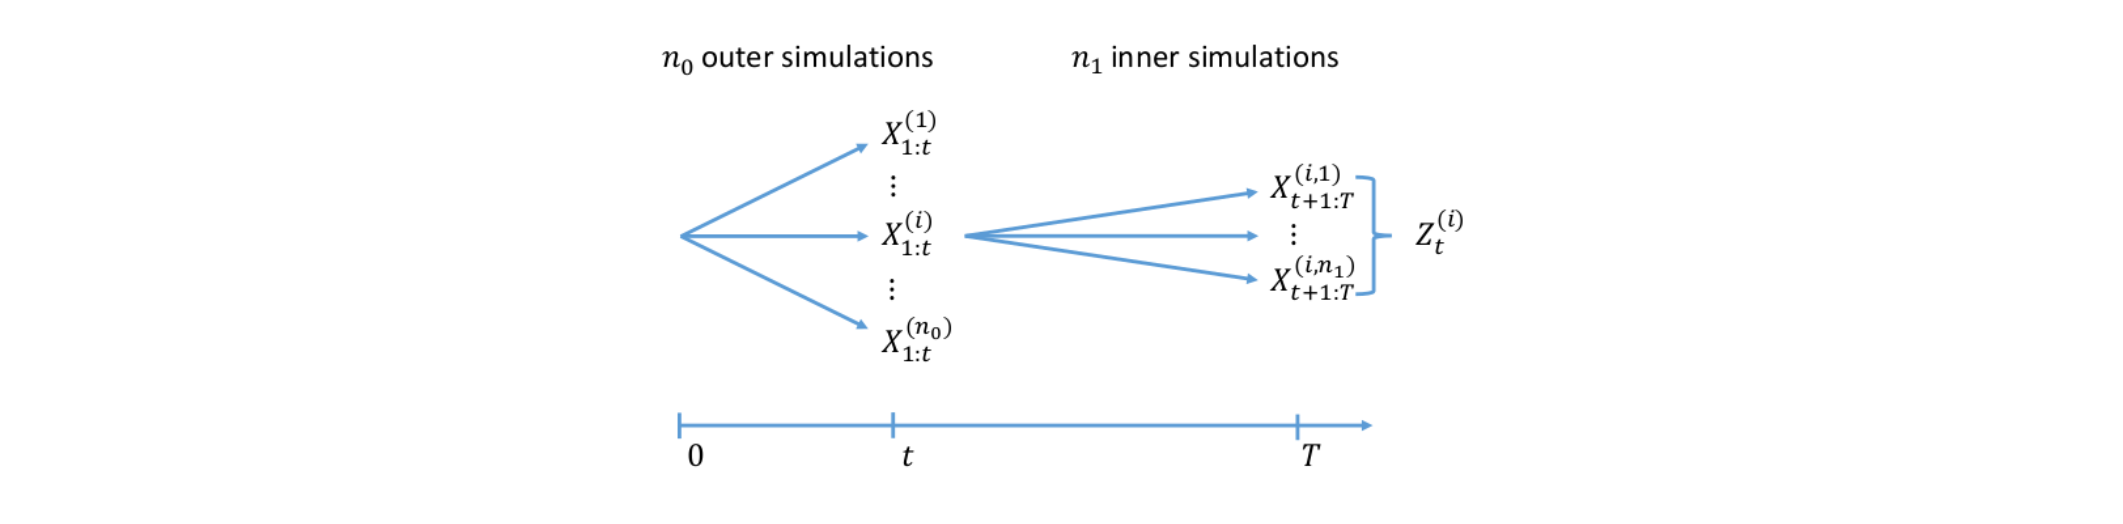

#### 3.2.2. nMC Results

The authors use the results of a Nested Monte-Carlo method as a reference to evaluate their ML model. Indeed, they assume that the nMC is a popular method used to solve our problem, so they set that the main goal of the study is to build another method that has less limitations and better performance than the nMC.

Besides that, to establish the benchmark value (the closest we can get to the ground truth without using a closed form solution) the authors provided the results of a very large nested Monte Carlo simulation, with $1.000.000$ outer simulations ($n_0$) and $100.000$ inner simulations ($n_1$). The result of this "benchmark simulation" is given by the datasets `call_annual_5y_HW_1million_z1dist.csv` and `call_annual_40y_HW_1million_z1dist.csv` shown in the previous section _3.1. Input Data / Test Data (Benchmark Data)_.

##### Present Value and Expected Shortfall nMC (Authors Result)

**(TABLE 2 - PAPER)** Nested Monte Carlo (nMC), comparison of present value (50,000 total samples)

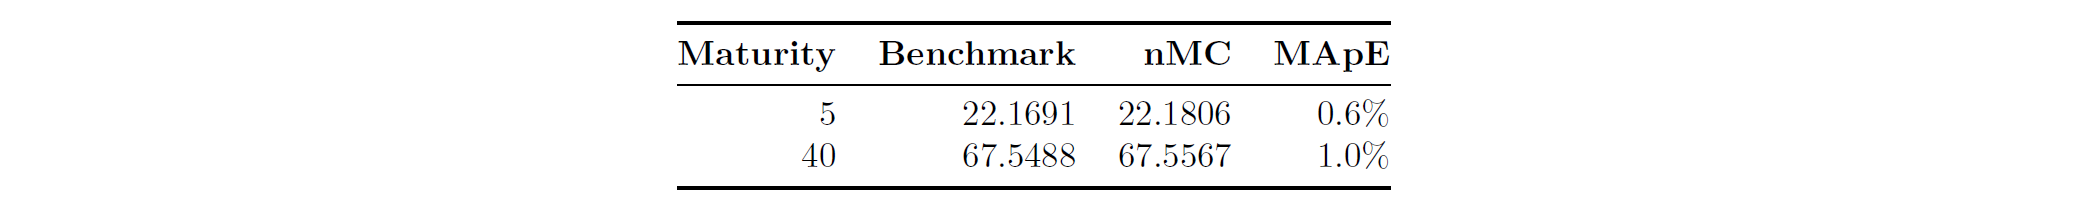

**(TABLE 3 - PAPER)** Nested Monte Carlo, comparison of expected shortfall for nested Monte Carlo (50,000 total
samples)

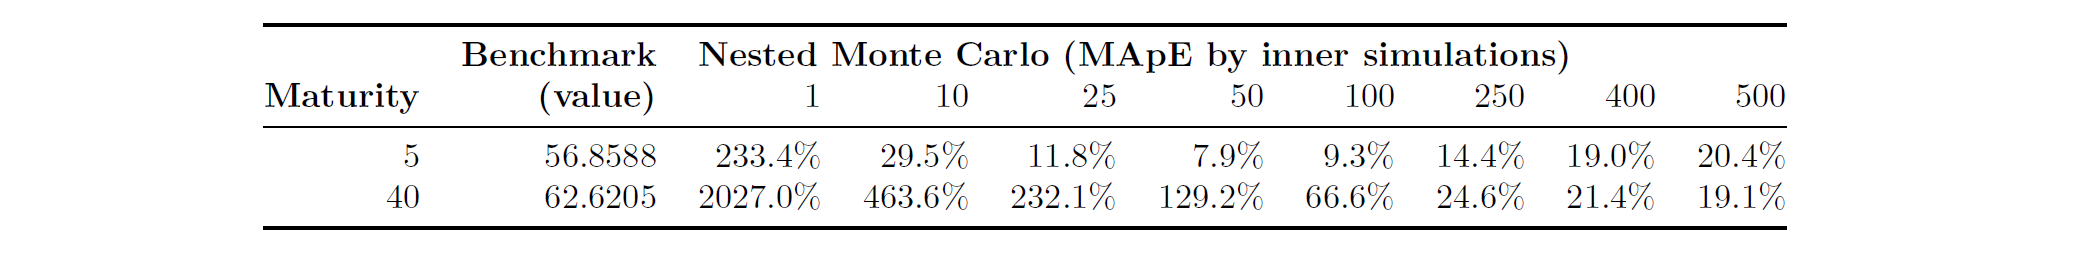

The optimal number of inner simulation for the 5-year European Call is 50
The optimal number of inner simulation for the 40-year European Call is 500


Text(0.5, 1.0, '40-Years PV MApE by Inner Simulations')

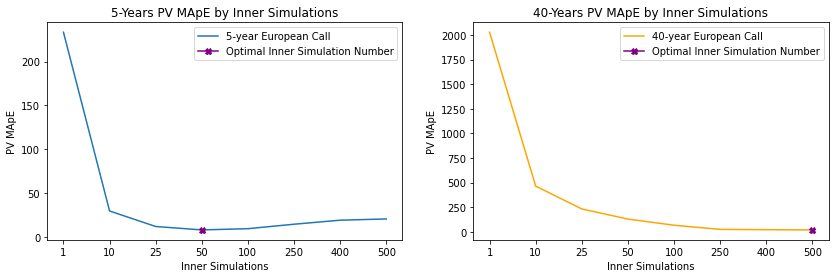

In [16]:
number_inner_simulations = ['1', '10', '25', '50', '100', '250', '400', '500']

plt.rcParams['figure.figsize'] = [14, 4]


pv_MApE_5y = [233.4, 29.5, 11.8, 7.9, 9.3, 14.4, 19.0, 20.4]

optimal_5y = number_inner_simulations[pv_MApE_5y.index(min(pv_MApE_5y))]
print(f"The optimal number of inner simulation for the 5-year European Call is {optimal_5y}")

plt.subplot(1, 2, 1)
plt.plot(number_inner_simulations, pv_MApE_5y, label=f"5-year European Call")
plt.plot(optimal_5y, 
         min(pv_MApE_5y),
         color = "purple", 
         label=f"Optimal Inner Simulation Number",
         marker = "X")
plt.legend()
plt.ylabel("PV MApE")
plt.xlabel("Inner Simulations")
plt.title("5-Years PV MApE by Inner Simulations")


pv_MApE_40y = [2027.0, 463.6, 232.1, 129.2, 66.6, 24.6, 21.4, 19.1]

optimal_40y = number_inner_simulations[pv_MApE_40y.index(min(pv_MApE_40y))]
print(f"The optimal number of inner simulation for the 40-year European Call is {optimal_40y}")

plt.subplot(1, 2, 2)
plt.plot(number_inner_simulations, pv_MApE_40y, label=f"40-year European Call", color="orange")
plt.plot(optimal_40y, 
         min(pv_MApE_40y),
         color = "purple", 
         label=f"Optimal Inner Simulation Number",
         marker = "X")
plt.legend()
plt.ylabel("PV MApE")
plt.xlabel("Inner Simulations")
plt.title("40-Years PV MApE by Inner Simulations")

**(TABLE 4 - PAPER)** Nested Monte Carlo, comparison of present value and expected shortfall MApE (in percentage
points) for optimal inner-outer split

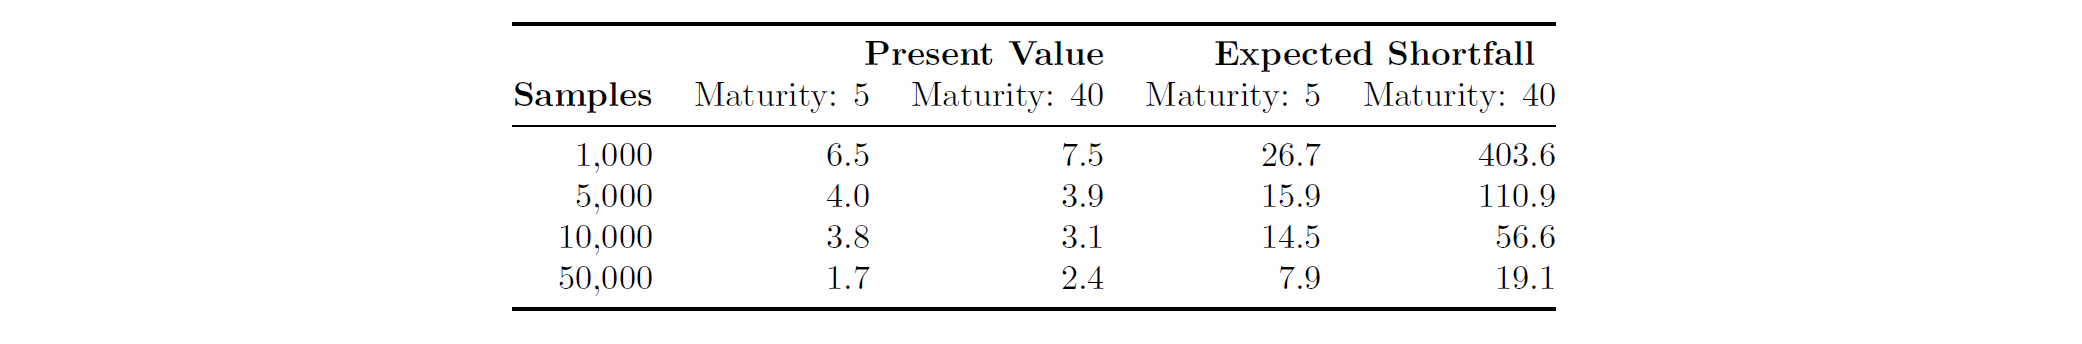

In the table above, the authors variate the number of samples with the optimal inner simulation number previously found. As expected, by using 50.000 samples we obtain the smaller MApE for the Present Value and for the Expected Shortfall in both European Call types analyzed.

At the end, the authors stated that the optimal way (considering the tested options) is to consider:

- 50.000 Samples and 50 inner simulations for the 5-year European Call
- 50.000 Samples and 500 inner simulations for the 40-year European Call

The results of this last table in particular are those used as reference to compare to the results of the proposed ML method.

##### Present Value and Expected Shortfall nMC (Paper Replication)

In this section, we tried to replicate the results of the authors nMC simulation, which is used for future comparison with their ML approach.

In [17]:
def nMC_pv_es (data_benchmark_5y, data_5y, data_benchmark_40y, data_40y, number_samples):
    
    ###########
    # Nested Monte Carlo (nMC), comparison of present value (50,000 total samples)
    ###########
    nMC_pv = pd.DataFrame([])
    
    ### Maturity
    nMC_pv["Maturity"] = [5, 40]
    
    
    ### Benchmark data
    pv_benchmark_5y = round(np.mean(data_benchmark_5y["V"]), 4)
    pv_benchmark_40y = round(np.mean(data_benchmark_40y["V"]), 4)
    
    nMC_pv["Benchmark"] = [pv_benchmark_5y, pv_benchmark_40y]
    
    
    ### nMC PV
    V_dist_5y_pv = pd.DataFrame([])
    data_5y_sample_pv = data_5y.sample(50000)
    V_dist_5y_pv["V"] = abs((data_5y_sample_pv["S_0"][5] - 100).clip(0, None)/data_5y_sample_pv["cash_0"][5])
    nMC_pv_5y = round(np.mean(V_dist_5y_pv["V"]), 4)
    
    V_dist_40y_pv = pd.DataFrame([])
    data_40y_sample_pv = data_40y.sample(50000)
    V_dist_40y_pv["V"] = abs((data_40y_sample_pv["S_0"][40] - 100).clip(0, None)/data_40y_sample_pv["cash_0"][40])
    nMC_pv_40y = round(np.mean(V_dist_40y_pv["V"]), 4)
    
    nMC_pv["nMC"] = [nMC_pv_5y, nMC_pv_40y]
    
    
    ### PV MApE Benchmark X nMC
    pv_MApE_5y = round(abs(nMC_pv_5y - pv_benchmark_5y)/pv_benchmark_5y*100, 2)
    pv_MApE_40y = round(abs(nMC_pv_40y - pv_benchmark_40y)/pv_benchmark_40y*100, 2)
    
    nMC_pv["MApE"] = [f"{pv_MApE_5y}%", f"{pv_MApE_40y}%"]
    
    
    ###########
    # Nested Monte Carlo, comparison of expected shortfall for nested Monte Carlo (50,000 total samples)
    ###########
    nMC_es = pd.DataFrame([])
    
    ### Maturity
    nMC_es["Maturity"] = [5, 40]
    
    ### Benchmark data
    es_benchmark_5y = round(calc_stats(data_benchmark_5y)["upper_es (99%)"], 4)
    es_benchmark_40y = round(calc_stats(data_benchmark_40y)["upper_es (99%)"], 4)
    
    nMC_es["Benchmark"] = [es_benchmark_5y, es_benchmark_40y]
    
    for j in range(len(number_samples)):
        
        es_MApE_5y = []
        es_MApE_40y = []
        
        for i in range(number_samples[j]):
            
            V_dist_5y_es = pd.DataFrame([])
            data_5y_sample_es = data_5y.sample(50000)
            V_dist_5y_es["V"] = abs((data_5y_sample_es["S_0"][5] - 100).clip(0, None)/data_5y_sample_es["cash_0"][5])
            es_MApE_5y_sample = calc_stats(V_dist_5y_es)["upper_es (99%)"]
            es_MApE_5y += [100*abs(es_MApE_5y_sample - es_benchmark_5y)/es_benchmark_5y]
            
            
            V_dist_40y_es = pd.DataFrame([])
            data_40y_sample_es = data_40y.sample(50000)
            V_dist_40y_es["V"] = abs((data_40y_sample_es["S_0"][40] - 100).clip(0, None)/data_40y_sample_es["cash_0"][40])
            es_MApE_40y_sample = calc_stats(V_dist_40y_es)["upper_es (99%)"]
            es_MApE_40y += [100*abs(es_MApE_40y_sample - es_benchmark_40y)/es_benchmark_40y]
         
        
        nMC_es[f"nMC w/ {number_samples[j]} inner stage simulation"] = [f"{round(np.mean(es_MApE_5y), 2)}%", 
                                                      f"{round(np.mean(es_MApE_40y), 2)}%"]
    
    return nMC_pv, nMC_es
    

In [18]:
data_benchmark_5y = test_data_5y
data_5y = train_data_5y
data_benchmark_40y = test_data_40y
data_40y = train_data_40y
number_samples = [1]

In [19]:
nMC_pv, nMC_es = nMC_pv_es (data_benchmark_5y, data_5y, data_benchmark_40y, data_40y, number_samples)

**(TABLE 2 - REPLICATION)** Nested Monte Carlo (nMC), comparison of present value (50,000 total samples)

The following table given by the DataFrame `nMC_pv` corresponds to the Table 2 of the paper. We remark with no surprise that the our nMC values aren't exactly the same of the Table 2 of the paper due to the randomness of the 50.000 samples chosen as input for the model. 

In [20]:
nMC_pv

,Maturity,Benchmark,nMC,MApE
0,5,22.1691,22.0642,0.47%
1,40,67.5488,66.8711,1.0%


**(TABLE 3 - REPLICATION)** Nested Monte Carlo, comparison of expected shortfall for nested Monte Carlo (50,000 total
samples)

The following table given by the DataFrame `nMC_es` was an attempt to reproduce the Table 3 of the paper. However, we found a lack of information concerning the parameters used by the authors when simulating the interest rate in the case where the inner stage has more than one simulation. The training datasets provided by them (`call_annual_5y_HW_training_data` and `call_annual_40y_HW_training_data`) have only one simulation path for each outer sample (inner stage contains only 1 simulation) and, to simulate more paths coming from an outer sample, it is necessary to know the parameters used to calculate the interest rate ($\kappa$, $b(t)$, $\sigma$ parameters of the equation (1)) in order to calculate the _Equity Index_ and the _Cash Account_ values. Unfortunately, these parameters weren't provided. So, we were just able to precisely simulate the nMC for 1 inner stage simulation, which corresponds to flat, not nested, Monte Carlo.

In [21]:
nMC_es

,Maturity,Benchmark,nMC w/ 1 inner stage simulation
0,5,56.8588,230.39%
1,40,62.6205,1974.46%


**(TABLE 4 - REPLICATION)** Nested Monte Carlo, comparison of present value and expected shortfall MApE (in percentage points) for optimal inner-outer split

Due to the limitation presented above, since the Table 4 contains the simulated values for nMC with 50 (5-year European Call) and 500 (40-year European Call) inner samples, we weren't able to reproduce this table neither.

### 3.3. Machine Learning Approach

#### 3.3.1 Theory

##### 3.3.1.1. Context and Motivation

The motivation of the authors in creating this ML method was to give an alternative method in the calculation of conditional expectations, since Monte-Carlo methods suffer from problems with both accuracy and speed. According to the authors, other alternative methods already exist, but they usually are not data-driven or do not have a good quality of the approximation.

In this context, the paper present a method that overcomes or greatly diminishes these problems. Indeed, the entire process is data-driven (free of manual steps) and, as shown in the pratical real-world example of an European Call, it provides an accurate estimation for pricing and risk measuring in terms of runtime and number of samples being used.

The remarkable results of their methods are due to two key factors:
- The conditional expectations are calculated in closed-form
- The feature learning strategy, which allows to tackle the notorious curse of dimensionality

So, we can conclude that the method was entirely designed to address the computational challenges described and illustrated in the example of the nMC.

##### 3.3.1.2. Math description of the method

The ML method strategy can be decomposed in two stages:

1. **We decrease the dimension of the initial database from $d \times T$ to $m$ by generating new $m$-dimension feature map, where $d$ is the stochastic driver dimension ($d=3$ in our example), $T$ is the time interval ($T=5$ or $T=40$ in our example), and $m \in \mathbb{N}$ is a fixed dimension.**

For every $\theta \in \Theta$, there are functions of news features $\phi_{\theta,i}:R^{dT}\rightarrow R$ for $i=1,...,m$. More precisely, the linear dimensionality reduction can be described as:

$$\phi_{\theta,i}(x)=g_i(A^\mathsf{T}x+b)\tag{4}$$

where each $g_i$ is an exogenously given function $g_i:R^p\rightarrow R, i=1,...,m,$ for $p\in N$, and $A$ is the weight matrix and $b$ is the bias vector, which by the way form the parameter $\theta=(A,b)$, member of a subset $\Theta \subseteq R^{dT \times p} \times R^p$.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The generation of new features (combination of initial features) is based on the assuption of conditional expectations $\mathbb{E}_t^\mathbb{Q}[\phi_\theta(X)]=G_{\theta,t}(X_1,...,X_t)$ where $G_{\theta,t}:R^{d \times t} \rightarrow R^m $. We have thus:

$$G_{\theta,t}(x_1,...,x_t)=\mathbb{E}^\mathbb{Q}[\phi_\theta(x_1,...,x_t,X_{t+1},...,X_T)]$$

2. **We optimise the weights of the new features by minimizing the square errors when regressing against its terminal value.**

After the preparation of the new feature map, we modelise $f$, the function of terminal value according to the features base $\{\phi_{\theta,1},...,\phi_{\theta,m}\}$. More precisely:

$$f_\theta=\sum_{i=1}^m \phi_{\theta,i}\beta_{\theta,i}=\phi_\theta^\mathsf{T}\beta_\theta$$

where $\beta=\beta_\theta \in R^m$ solves:

$$\underset{\beta \in R^m}{min}\|f-\phi_\theta^\mathsf{T} \beta \|$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Finally, we can obtain the approximate value process based on optimized parameters and new features:

$$V_{\theta,t}=G_{\theta,t}(X_1,...,X_t)^\mathsf{T} \beta_\theta$$

##### 3.3.1.3. Types of Basis Functions $\phi$

The performance of the ML approach proposed by the authors hinges on the choice of the basis functions. Therefore, the paper motivates the study of three different specifications of basis functions. In more detail: a **full polynomial basis**, a
**polynomial feature map with linear dimensionality reduction**, and a **shallow neural network**.

- **Full Polynomial Basis**

The authors initially propose a non-weighted and non-biased case ($\Theta = \{(I_{dT}, 0)\}$), with a feature map $\phi$ composed of a basis of the space of all polynomias of degree $\delta$ or less:

$$ \text{Pol}_{\delta}(\mathbb{R}^{dT}) \ = \ \text{span}\{x^{\alpha} | \alpha \in \mathbb{N}_0^{dT}, |\alpha| \leq \delta\} $$

By using this approach, we suffer from the curse of dimensionality, since every polynomial is used in the projection of $f$ in previously defined polynomial space. Indeed, the number of basis functions $m$ is given by the following function of $d$ and $T$:

$$ m \ = \ \text{dim} \text{Pol}_{\delta}(\mathbb{R}^{dT}) \ = \ \dbinom{dT + \delta}{dT} $$

Using the parameters of our example and $\delta = 3$, we have that:

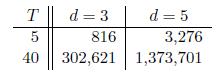

In the table above, we can see that the dimension $m$ quickly becomes larger than the training sample size in practice.
 <font color='red'> **(TO BE CONTINUED...)** </font>

We give a simple example to explain the mecanism of generating new features from the initial features. When we have $x_{d,T}$ where $d={1,2}$ features for $T=1$ (omitted in notation) and we define $\delta=2$, we have thus finally $C_{2\times 1+ 2}^2$ features 
$\{1,x_1,x_1^2,x_1x_2,x_2,x_2^2\}$.

We now generate the full polynomial basis as below:

In [26]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

In [41]:
def polynomialFeatures(data_set, degree): 
    #features = []
    poly = PolynomialFeatures(degree)
    poly.fit_transform(data_set)
    print("The initial shape of the data base is:")
    print(data_set.shape)
    data_set_new = poly.fit_transform(data_set)
    print("The new shape of the feauture map when delta is "+ str(degree) +":")
    print(data_set_new.shape)
    #data_set_new=data_set_new.set_index('id')
    return data_set_new

In [44]:
## Out-of-sample testing

In [42]:
train_inputs_5y.columns

Index(['X_1', 'X_2', 'X_3'], dtype='object')

In [43]:
data_set=train_inputs_5y
degree=3
polynomialFeatures(data_set, degree)

The initial shape of the data base is:
(1000000, 3)
The new shape of the feauture map when delta is 3:
(1000000, 20)


array([[ 1.00000000e+00, -7.78494476e-01, -1.91096727e-01, ...,
         6.81737059e-02, -6.65999738e-01,  6.50625700e+00],
       [ 1.00000000e+00, -1.87797206e-01, -1.11656250e+00, ...,
         2.85157137e-01, -5.84143266e-02,  1.19661516e-02],
       [ 1.00000000e+00, -1.29998143e+00,  1.61425352e+00, ...,
         4.69302550e+00,  5.23589103e+00,  5.84155252e+00],
       ...,
       [ 1.00000000e+00,  6.33306365e-01,  5.67887143e-01, ...,
         5.56317931e-02,  1.68989611e-02,  5.13330365e-03],
       [ 1.00000000e+00,  6.41591199e-01, -4.37184515e-01, ...,
         2.74669958e-01, -9.02875794e-01,  2.96786989e+00],
       [ 1.00000000e+00,  1.16730105e+00,  9.43650553e-01, ...,
         1.49641575e-01,  2.66483880e-02,  4.74558345e-03]])

In [45]:
## Train and Validation Data

In [50]:
data_set=train_data_5y.iloc[:,:15]
degree=3
polynomialFeatures(data_set, degree)

C:\Users\Patricia\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Patricia\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


The initial shape of the data base is:
(500000, 15)


C:\Users\Patricia\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Patricia\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


The new shape of the feauture map when delta is 3:
(500000, 816)


array([[ 1.00000000e+00, -2.82880496e-01, -2.80114485e-01, ...,
         1.02352342e-01, -3.18017796e-01,  9.88109471e-01],
       [ 1.00000000e+00, -4.48382165e-01,  1.08609253e-01, ...,
        -1.61829683e+00, -3.13900996e-01, -6.08873684e-02],
       [ 1.00000000e+00,  7.82956320e-01, -3.81633320e-01, ...,
        -3.09701697e-01,  2.22690048e-01, -1.60124591e-01],
       ...,
       [ 1.00000000e+00,  1.05569828e+00,  6.97634290e-03, ...,
        -5.07503171e-01,  3.13283942e-01, -1.93391557e-01],
       [ 1.00000000e+00, -3.86470770e-01, -4.22631426e-01, ...,
         1.36048651e-01, -2.46398946e-01,  4.46255368e-01],
       [ 1.00000000e+00,  7.79521419e-01, -6.52080086e-01, ...,
        -7.74907999e-05, -3.15011546e-03, -1.28056846e-01]])

In [51]:
data_set=train_data_5y.iloc[:,:25]
degree=3
polynomialFeatures(data_set, degree)

C:\Users\Patricia\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Patricia\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


MemoryError: Unable to allocate 12.2 GiB for an array with shape (500000, 3276) and data type float64

In [52]:
data_set=train_data_5y.iloc[:1000,:25]
degree=3
polynomialFeatures(data_set, degree)

The initial shape of the data base is:
(1000, 25)
The new shape of the feauture map when delta is 3:
(1000, 3276)


C:\Users\Patricia\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Patricia\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Patricia\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Patricia\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will

array([[ 1.00000000e+00, -2.82880496e-01, -2.80114485e-01, ...,
         3.80469629e-10,  4.68310253e-09,  5.76431011e-08],
       [ 1.00000000e+00, -4.48382165e-01,  1.08609253e-01, ...,
         6.91382474e-06,  4.62399070e-06,  3.09254151e-06],
       [ 1.00000000e+00,  7.82956320e-01, -3.81633320e-01, ...,
         2.99577999e-06,  2.87336547e-06,  2.75595308e-06],
       ...,
       [ 1.00000000e+00, -5.99787479e-01,  7.02877564e-01, ...,
         6.28859037e-06,  8.73485743e-06,  1.21327245e-05],
       [ 1.00000000e+00, -3.94588080e-01, -1.10545755e-01, ...,
         3.86028948e-07,  1.02786734e-06,  2.73687057e-06],
       [ 1.00000000e+00, -5.07755565e-01,  8.07599619e-01, ...,
         7.17048400e-06,  6.10684256e-06,  5.20097751e-06]])

 <font color='red'> We can thus conclude that the full polynomial basis suffers from the explosion of dimensionality and even rapidly excess the calculate capacity of my computer system when we add to the polynomials of degree and the dimensionality of the data base. In practice, we will select a certain amount of features at the first time then generate the full polynomial basis or do sampling for the first time.
    <br> We will choose the data base 5-year Europen Call and fix the sample number at 5000 for the generating of features pool and modelisation.</br> </font>

The data sets for the generating of features pool and machine learning models training.

1. **Train and Validation Data:**
    - 5-year Europen Call: `call_annual_5y_HW_training_data.h5`

2. **Out-of-sample testing:**
    - 5-year Europen Call: `call_annual_5y_HW_1million_outer_x.csv`

#### Train and Validation Data

In [53]:
train_data_5y = pd.read_hdf(path+'/data/call_annual_5y_HW_training_data.h5')

pd.set_option('display.max_columns', None)
train_data_5y.head(3)

variable_name,ind_Z_0,ind_Z_1,ind_Z_2,Z_r_c_0,Z_r_c_1,Z_r_e_0,Z_r_e_1,cash_0,r_0,S_0,call_0,ind_Z_0,ind_Z_1,ind_Z_2,Z_r_c_0,Z_r_c_1,Z_r_e_0,Z_r_e_1,cash_0,r_0,S_0,call_0,ind_Z_0,ind_Z_1,ind_Z_2,Z_r_c_0,Z_r_c_1,Z_r_e_0,Z_r_e_1,cash_0,r_0,S_0,call_0,ind_Z_0,ind_Z_1,ind_Z_2,Z_r_c_0,Z_r_c_1,Z_r_e_0,Z_r_e_1,cash_0,r_0,S_0,call_0,ind_Z_0,ind_Z_1,ind_Z_2,Z_r_c_0,Z_r_c_1,Z_r_e_0,Z_r_e_1,cash_0,r_0,S_0,call_0
time,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,5
simulation,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.282880,0.499004,0.544870,-0.282880,0.342471,-0.282880,0.477285,1.021699,0.017575,110.177698,0.0,-0.280114,1.419073,0.497429,-0.280114,1.185460,-0.280114,0.431356,1.046318,0.016296,120.563431,0.0,-1.737776,1.100434,-2.912138,-1.737776,0.305836,-1.737776,-3.200856,1.065913,0.003924,63.469456,0.0,-1.250346,0.089398,-0.320564,-1.250346,-0.422628,-1.250346,-0.564156,1.071590,0.000314,55.870670,0.0,-0.527155,1.352286,0.996021,-0.527155,1.024685,-0.527155,0.870466,1.081766,0.003863,65.797628,0.0
1,-0.448382,-1.521676,-0.064078,-0.448382,-1.573240,-0.448382,-0.152460,1.012296,0.016259,96.245178,0.0,0.108609,-0.764738,0.065217,0.108609,-0.655926,0.108609,0.085621,1.026451,0.018588,97.310806,0.0,-0.534241,-2.140202,-0.674467,-0.534241,-2.173835,-0.534241,-0.767688,1.035099,0.014883,82.496999,0.0,0.614058,-2.239580,-2.028187,0.614058,-1.801508,0.614058,-1.864397,1.042663,0.021784,56.101545,0.0,-0.818455,-0.905896,-0.393407,-0.818455,-1.159094,-0.818455,-0.549150,1.059274,0.014569,50.055867,0.0
2,0.782956,-0.827774,-0.011047,0.782956,-0.441553,0.782956,0.145767,1.017840,0.026049,102.719976,0.0,-0.381633,0.101467,-1.307610,-0.381633,-0.061119,-0.381633,-1.357518,1.043046,0.020628,78.646644,0.0,-1.394899,-0.025959,-0.262453,-1.394899,-0.586498,-1.394899,-0.536130,1.061626,0.009278,70.484690,0.0,0.140296,1.497529,0.755200,0.140296,1.426854,0.140296,0.768001,1.081397,0.014618,82.059781,0.0,-0.340791,0.260470,-0.543024,-0.340791,0.100847,-0.340791,-0.600211,1.099111,0.014020,72.504879,0.0


In [57]:
train_data_5y.shape

(500000, 55)

###### Generating the full polynomial basis

In [59]:
import random

In [60]:
random.seed(888)

In [63]:
train_data_5y_sample5000=train_data_5y.sample(n=5000,replace=False,random_state=1)

In [64]:
train_data_5y_sample5000

variable_name,ind_Z_0,ind_Z_1,ind_Z_2,Z_r_c_0,Z_r_c_1,Z_r_e_0,Z_r_e_1,cash_0,r_0,S_0,call_0,ind_Z_0,ind_Z_1,ind_Z_2,Z_r_c_0,Z_r_c_1,Z_r_e_0,Z_r_e_1,cash_0,r_0,S_0,call_0,ind_Z_0,ind_Z_1,ind_Z_2,Z_r_c_0,Z_r_c_1,Z_r_e_0,Z_r_e_1,cash_0,r_0,S_0,call_0,ind_Z_0,ind_Z_1,ind_Z_2,Z_r_c_0,Z_r_c_1,Z_r_e_0,Z_r_e_1,cash_0,r_0,S_0,call_0,ind_Z_0,ind_Z_1,ind_Z_2,Z_r_c_0,Z_r_c_1,Z_r_e_0,Z_r_e_1,cash_0,r_0,S_0,call_0
time,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5,5,5
simulation,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
352806,-1.419399,0.662126,-0.371638,-1.419399,0.033223,-1.419399,-0.648009,1.020175,0.008539,87.842293,0.0,0.297824,-0.006826,1.383412,0.297824,0.113906,0.297824,1.415026,1.032003,0.015410,115.593032,0.0,0.923443,0.956664,-0.116830,0.923443,1.247902,0.923443,0.070219,1.055386,0.024545,117.510030,0.0,-0.705671,-0.024704,0.120596,-0.705671,-0.307294,-0.705671,-0.022975,1.078965,0.017152,117.216782,0.0,-0.553706,-0.428630,-0.773260,-0.553706,-0.615583,-0.553706,-0.868379,1.095035,0.013864,98.016278,0.000000
417824,-1.038938,-0.829475,1.537588,-1.038938,-1.178117,-1.038938,1.298735,1.014228,0.011564,128.901033,0.0,-0.492677,0.524822,-1.241983,-0.492677,0.281457,-0.492677,-1.315425,1.029264,0.010960,98.561070,0.0,-1.468860,1.413539,1.666062,-1.468860,0.700819,-1.468860,1.338629,1.046139,0.002825,128.337514,0.0,0.496989,-1.119224,-0.920249,0.496989,-0.823600,0.496989,-0.802259,1.048770,0.013540,107.417616,0.0,-0.297392,-1.415823,-0.145584,-0.297392,-1.415469,-0.297392,-0.202121,1.057280,0.013712,101.939682,1.939682
469847,-0.020786,-1.464676,-0.023635,-0.020786,-1.348579,-0.020786,-0.027315,1.013394,0.019659,98.791565,0.0,0.181383,1.192009,0.863551,0.181383,1.163876,0.181383,0.882381,1.039408,0.021229,118.490671,0.0,0.211746,0.049235,-0.471117,0.211746,0.130475,0.211746,-0.419249,1.062092,0.022416,109.133739,0.0,0.255624,-0.076562,-0.254851,0.255624,0.033072,0.255624,-0.198577,1.085786,0.023503,105.101055,0.0,-1.182817,-2.274538,0.929164,-1.182817,-2.558410,-1.182817,0.673828,1.097143,0.012715,119.115404,19.115404
407746,-1.188916,-2.026076,0.816502,-1.188916,-2.333526,-1.188916,0.562222,1.008588,0.010372,110.627148,0.0,0.849302,0.712464,-0.236235,0.849302,0.994546,0.849302,-0.061601,1.026106,0.020906,108.969195,0.0,-0.680001,-0.789171,-0.423302,-0.680001,-0.996433,-0.680001,-0.550750,1.042548,0.015130,97.203982,0.0,1.496990,0.339507,0.642571,1.496990,0.914584,1.496990,0.928987,1.064231,0.028954,117.119414,0.0,-0.473246,0.260245,0.409079,-0.473246,0.047205,-0.473246,0.306165,1.093653,0.021663,125.423731,25.423731
469848,0.808520,-1.083237,0.231918,0.808520,-0.664990,0.808520,0.388936,1.016743,0.026252,107.722878,0.0,-0.702151,-1.052258,-0.438934,-0.702151,-1.246096,-0.702151,-0.570496,1.036145,0.018203,96.001623,0.0,1.442393,0.469592,-1.617818,1.442393,1.011587,1.442393,-1.296653,1.060742,0.030365,74.328632,0.0,0.419877,2.067832,2.230013,0.419877,2.061478,0.419877,2.268933,1.101947,0.029631,119.151125,0.0,-0.639385,-1.949057,-1.665861,-0.639385,-2.041355,-0.639385,-1.760081,1.121650,0.020752,83.604634,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467095,1.030871,0.197643,-0.965275,1.030871,0.596731,1.030871,-0.739599,1.022954,0.028020,86.482749,0.0,2.552094,-0.415524,1.936319,2.552094,0.649386,2.552094,2.407617,1.053520,0.045149,141.303590,0.0,1.195915,0.504597,1.443691,1.195915,0.944180,1.195915,1.653705,1.101285,0.044749,201.540941,0.0,0.606431,-1.019522,-0.716476,0.606431,-0.688220,0.606431,-0.580714,1.141833,0.039838,182.364337,0.0,0.693518,0.217785,0.006876,0.693518,0.479062,0.693518,0.145441,1.185963,0.037541,191.141718,91.141718
295160,0.152395,0.228026,1.271710,0.152395,0.270127,0.152395,1.276495,1.021343,0.021036,129.229164,0.0,-0.489258,1.578791,-0.102727,-0.489258,

In [65]:
data_set=train_data_5y_sample5000
degree=3
polynomialFeatures(data_set, degree)

C:\Users\Patricia\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Patricia\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


The initial shape of the data base is:
(5000, 55)


C:\Users\Patricia\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Patricia\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


The new shape of the feauture map when delta is 3:
(5000, 30856)


array([[ 1.00000000e+00, -1.41939866e+00,  6.62126399e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00, -1.03893811e+00, -8.29474537e-01, ...,
         2.01565935e+04,  3.83534510e+02,  7.29779666e+00],
       [ 1.00000000e+00, -2.07857373e-02, -1.46467582e+00, ...,
         2.71218523e+05,  4.35246117e+04,  6.98474354e+03],
       ...,
       [ 1.00000000e+00, -1.16625355e+00,  1.70406012e+00, ...,
         1.86102542e+04,  3.28332039e+02,  5.79260908e+00],
       [ 1.00000000e+00,  6.98170224e-01,  1.35982180e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  1.91322532e+00, -3.92433394e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [66]:
data_set=train_data_5y_sample5000
degree=3
train_data_5y_sample5000_full_polyn=polynomialFeatures(data_set, degree)

C:\Users\Patricia\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Patricia\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


The initial shape of the data base is:
(5000, 55)


C:\Users\Patricia\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Patricia\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


The new shape of the feauture map when delta is 3:
(5000, 30856)


In [71]:
df_full_polyn=pd.DataFrame(train_data_5y_sample5000_full_polyn)

#### Out-of-sample testing

In [55]:
oot_data_5y=pd.read_csv(path+'/data/call_annual_5y_HW_1million_outer_x.csv')
oot_data_5y.columns = ['id', 'X_1', 'X_2', 'X_3']
oot_data_5y = oot_data_5y.set_index('id')
oot_data_5y.head(3)

,X_1,X_2,X_3
id,,,
0,-0.778494,-0.191097,1.866854
1,-0.187797,-1.116563,0.228727
2,-1.299981,1.614254,1.800982


###### Generating the full polynomial basis

- **Polynomial Feature Map with the Linear Dimensionality Reduction**

<font color='red'> **(TO BE CONTINUED...)** </font>


The linear dimensionality reduction to $p-dimension$ ($Pol_\delta(\mathbb{R}^p$) is based on the $m-dimension$ polynomial basis functions $\{g_1,...,g_m\}$ we generated by the full polynomial basis.We choose or optimize a $p$ who is smaller than $dT$. 

It is at this step that we take the weight matrices $A$ and bias vectors $b$. The set of all orthonormal $p-frames$ in $\mathbb{R^{dT}}$ is as follow:
$$V_p(\mathbb{R}^{dT})= \{A \in \mathbb{R}^{dT \times p} |A^{T}A=I_p\}$$

The dimensionality reduction with matrix manifold $V_p(\mathbb{R}^{dT}) \times \mathbb{R}^m$ by the linear mapping $A$ of $\mathbb R^{dT}$ onto $\mathbb R^{p}$ in this project is executed in the spirit of the article Linear Dimensionality Reduction: Survey, Insights, and Generalizations wrote by John P. Cunningham, Zoubin Ghahramani in 2015. Thus, principal component analysis, factor analysis, linear multidimensional scaling, Fisher's linear discriminant analysis, canonical correlations analysis, maximum autocorrelation factors, slow feature analysis and any other dimensionality reduction techniques could be used in this step. Otherwise, every polynomial basis function $g_i$ could be used in composing $Pol_\delta(\mathbb{R}^p) $.

We test the methods of princepal component analysis in this projet as following:

In [75]:
# evaluate pca with logistic regression algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_redundant=10, random_state=7)
# define the pipeline
steps = [('pca', PCA(n_components=10)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))


Accuracy: 0.824 (0.034)


We reuse the dataset of full polynomial basis $df\_full\_polyn$ on the previous step to apply PCA

In [82]:
! pip install xarray

You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [77]:
df_redu_pca_polyn=df_full_polyn.make_classification(n_samples=1000, n_features=20, *, n_informative=2, n_redundant=2, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)

SyntaxError: invalid syntax (<ipython-input-77-c8f43fc37cad>, line 1)

In [79]:
from sklearn.datasets import make_classification

- **Shallow Neural Network**

For the third basis function type, the authors chose a neural network of the single-layer feed-forward type with the rectified linear unit activation function (ReLU). In practical terms, we let $p=m$ and the features map will be expressed as:

$$ \phi_{(A,b),i} (x) \ = \ \phi_{(a_i,b_i)} (x) \ = \ \left(a_i^\mathsf{T} x + b_i\right)^+ $$

According to the authors, we can set the parameter $\theta_i = (a_i,b_i)$ as a point in the _unit sphere_ $S_{dT}$ in $\mathbb{R}^{dT+1}$ due to the positive homogeneity of the components of the feature map in the parameter.

##### 3.3.1.4. Regress-Now X Regress-Later

<font color='red'> **(TO BE CONTINUED...)** </font>


In the second setp of machine learning modelisation, "optimise the weights of the new features by minimizing the square errors when regressing against its terminal value" , we can choose $regress$ $now$ or $regress$ $later$.These methods have been presented in the paper "Simulation for American Options: Regression or Regression Later ?" of Paul Glasserman and Bin Yu in 2002.

The vector of regression coefficients for $regress now$ is as below:
$$(\hat \beta_{i0},...,\hat \beta_{iK})=(\sum^{b}_{j=1} \hat V_{i+1}(X_{i+1,j})\psi_i(X_{i,j})^T)(\sum^{b}_{j=1} \psi_i(X_{ij})\psi_i(X_{i,j})^T)^{-1}\tag{5}$$

The vector of regression coefficients for $regress later$ is as below:
$$(\hat \gamma_{i0},...,\hat \gamma_{iK})=(\sum^{b}_{j=1} \hat V^{+}_{i+1}(X_{i+1,j})\psi_{i+1}(X_{i+1,j})^T)(\sum^{b}_{j=1} \psi_{i+1}(X_{i+1,j})\psi_{i+1}(X_{i+1,j})^T)^{-1}\tag{6}$$

We can thus conclude that the actuel value by regression now depends on the actuel information while regress later tabkes into account the information at the end of the period because function (5) uses current basis function and function (6) uses later basis functions.

In the practice of this project, the $regress$ $later$ method have better performance for the prediction of final value.

#### 3.3.2 Replicating Martingale Method Results

The authors provided their results for the three basis functions exposed above, always comparing the outputs to the benchmark value provided by the _Test Data_ (`call_annual_5y_HW_1million_z1dist.csv` and `call_annual_40y_HW_1million_z1dist.csv`). The results for each basis functions were compared to their equivalent using a _Regress Now_ methodology and, as mentioned in the section $3.2$, to the _Nested Monte Carlo_ (nMC) results. 

##### Present Value and Expected Shortfall w/ Replicasting Martingale Method (Authors Result)

The following tables contain the comparison between the three function basis basis with their respective Regress-Now results, and with the nMC results done in the section 3.2 of this report, more specifically the results in the Table 4. For all the function basis, we can see how the replicating martingale outperforms the other two methods (Regress-Now and nMC) in the estimation of the present value and the 99% expected shortfall.

The following tables do not show results for the Full Polynomial basis under the replicating martingale approach for $T=40$ because, as we saw in the full polynomial basis section, there is a combinatorial explosion in the number of basis function as the dimensionality of the problem grows. Indeed, for $d=3$, $\delta=3$, and $T=40$, the number of functions is $302.621$, while the number of samples is $50.000$. The authors state that number of samples should be at least of the magnitude of the number of functions in order to represent a real-world scenario. It also becomes clear that the LDR approach allows high dimensional problems where the regress-later approach on a full polynomial basis would fail due to producing a very large number of basis functions, which leads to a computational problem due to time, memory constraints or not realistic scenarios.

The results show that even for a high-dimensional problem, the proposed method does not suffer from problem of accuracy, and its runtime is quite satisfatory when comparing to nMC approach.

It is important to mention that the authors' results show an excellent quality of the neural network replicating martingale in the European Call example, outperforming every other choice, except for the risk calculations with $1.000$ samples.

**(TABLE 7 - PAPER)** European call, comparison of present value MApE (in percentage points)

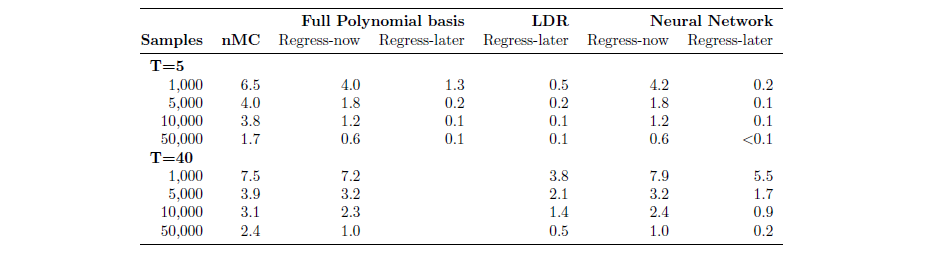

**(TABLE 8 - PAPER)** European call, comparison of expected shortfall MApE (in percentage points)

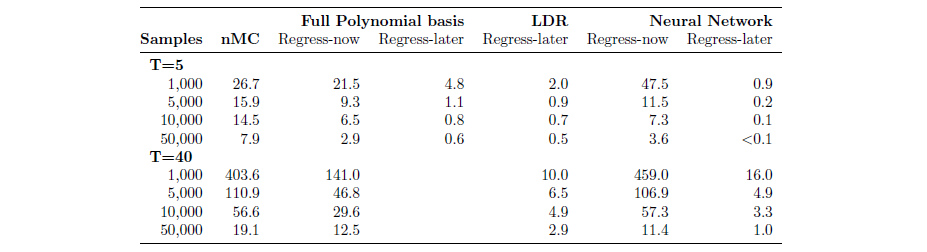

**(TABLE 11 - PAPER)** European call, comparison of runtime (in seconds), single core AMD Opteron 6380

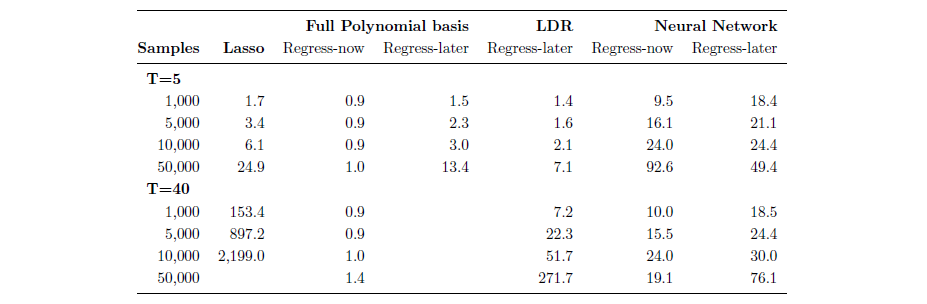

##### Present Value and Expected Shortfall w/ Replicating Martingale Method (Paper Replication)

Once again, the authors didn't give a lot of details about their programming strategies. We found a lack of information about the parameters used to obtain the features $\phi_\theta$ for the polynomial basis functions. To show you that we well understood the step-by-step proposed by the authors, we provide a function that generates an orthogonal basis for a given stochastic driven dataset in the _Appendix 2: Polynomial Orthogonal Base_. Using the coefficients of this orthogonal base gave by our function and the explicit $\phi_{\theta,i}$ gave by the authors, we can obtain our train dataset and obtain the results for the Present Value and the ES.

So, concerning the programming part, we decided to focus in the replication of the results for the Shallow Neural Network. Due to the lack of information of how the authors generated their numbers and due randomness of the $M$ samples chosen as input for the model, we do not have the exact match with the paper results, but they are satisfactorily close. 

###### Replicating Martingale Shallow Neural Networks (**European Call 5-years**)

In [21]:
def phi(X):
    npoints = X.shape[1] + 1
    ndim = X.shape[1]
       
    phi = []
    for i in range (len(X)):
        # sample spherical points
        spherical_points = np.random.randn(ndim, npoints)
        spherical_points /= np.linalg.norm(spherical_points, axis=0)
        
        # A and b
        A = []
        b = []
        for j in range (len(spherical_points)):
            A += [spherical_points[j][:-1]]
            b += [spherical_points[j][-1]]
        
        # phi
        phi += [np.dot(A, X[i]) + b]
        
    return np.maximum(phi, 0)

In [22]:
def shallow_nn (data, T, M):
    data["V0"] = abs((data["S_0"][T] - 100).clip(0, None)/data["cash_0"][T])
    variables = ["ind_Z_0", "ind_Z_1", "ind_Z_2"]
    time = [1, 2, 3, 4, 5]

    # X_Train
    X = data[list(itertools.product(variables, time))].values
    X_train = pd.DataFrame(phi(X))
    X_train.columns = [f"phi_{i+1}" for i in range(X_train.shape[1])]

    # Y_Train
    Y_train = data["V0"].values
    
    # Regression Model
    reg = LinearRegression()
    reg.fit(X_train,pd.Series(Y_train))
    y_pred = []
    X_train_ = X_train.sample(M).reset_index(drop=True)
    for i in range(M):
        y_pred += [reg.predict(np.array(X_train_.loc[i]).reshape(1, -1))[0]]
        
    return y_pred

In [28]:
pv_benchmark_5y = round(np.mean(data_benchmark_5y["V"]), 4)

M = [1000, 5000, 10000, 50000]

nn_5y = pd.DataFrame([])
nn_5y["Samples(T=5)"] = M
nn_5y["Shalow NN PV Authors"] = [.2, .1, .1, "<0.1"]

nn_MApE_pv_5y = []
for i in range (len(M)):
    y_pred_5y = pd.DataFrame([])
    y_pred_5y['V'] = shallow_nn (train_data_5y, 5, M[i])
    nn_MApE_pv_5y += [round(100*abs(np.mean((np.array(y_pred_5y) - pv_benchmark_5y)/pv_benchmark_5y)), 4)]   
    
nn_5y["Shallow NN PV Replication"] = np.array(nn_MApE_pv_5y)

nn_5y.set_index("Samples(T=5)")

,Shalow NN PV Authors,Shallow NN PV Replication
Samples(T=5),,
1000,0.2,0.4247
5000,0.1,0.1561
10000,0.1,0.1417
50000,<0.1,0.0953


## Conclusion & Comments

The article provides a computationally fast ML method for calculations in portfolio pricing and risk management when compared to the most common ones (usually Monte-Carlo techniques). According to the authors' results, besides being fast, the method appears to have good accuracy. To be honest, we were disappointed with the lack of information regarding the strategies used to obtain those results, which may raise questions about the efficiency of the method proposed. Besides that, even if the availability of the datasets used is good practice for the scientific community, it was extremely difficult to link the datasets to the paper parameters. The datasets are confusing and the notation used in the data columns doesn't match the paper's notation, which becomes one more obstacle when trying to reproduce the authors' results.

Having spoken of the practical part, the theory is very complete and full of examples, proofs, and explanations. This made easier the understanding of the methodology. However, sometimes we had the impression that the authors tried to complicate something simple.

One last comment concerns the organization of the articles. The first 5 pages are almost incomprehensible in the first reading. To understand what the authors meant on it, it was necessary to read it over and over again the whole paper. In other words, the paper doesn't exactly follow a chronology, which made it harder to understand the reasoning of the authors while reading it.

Despite all those critics and comments, once we well understood the method, the method is shown to be a good example of Machine Learning applied in a finance real-problem context. And, according to the authors' results, it seems to be an effective alternative for high-dimensional problems, which is the main "promise" of the method.

Finally, at least in the example proposed, the authors affirm that the Replicating Martingale method outperforms other methods in the literature and in use in the financial industry.

## Appendix

### Appendix 1: Math Description of the problem

Our goal is to obtain the distribution of the present value of a portfolio. To do so, we take into account the informations and cash flows between the initial time and the time at which the value is predicted.

In order to obtain the final cash flow, we can describe the terminal value at $T$ by the following formula:

$$f(X)=\sum_{t=1}^T \zeta_t$$

where $\zeta_t=\zeta_t(X_1,X_2,...,X_t)$ represents the cash flows measured by the filtration $F_t=\sigma(X_1,X_2,...,X_t)$, with $t=1,...,T$, generated by $X$. We denote by $\mathbb{Q}$ the distribution of $X$ on the path space $\Omega=R^{dT}$, where $T$ is the finite time horizon and $d$ the dimension of stochastic driver process.

Finally, the cum-dividend value process of the portfolio is described as:

$$V_t=\mathbb{E}^\mathbb{Q}_t\left[f(X)\right]=\sum_{s=1}^t \zeta_s+\mathbb{E}^\mathbb{Q}_t\left[\sum_{s=t+1}^T \zeta_s\right]$$

where $E^Q_t[.]=E^Q[.|F_t]$ is the $F_t$-conditional expectation. Thus, the value predicted is composed by the first term of the equation, which is accumulated cash flow at t, and the second one, which represents the time-t spot value.

Beides having an estimation of the present value, we are also interested in the Expected Shortfall of the distribution of present values, which is given by the formula:

$$ ES_{\alpha}(V) \ = \ \frac{1}{1-\alpha} \int_{1-\alpha}^{1} \text{VaR}_{\gamma}(V) d\gamma $$

where V represents the present value distribution with a \mathbb{P}-distribution function denoted by $F_V$, $\alpha \in (0,1)$ denotes the confidence level (we use a 99% confidence level in the pratical examples) and the VaR is the risk measure given by the formula:

$$ \text{VaR}_\alpha(V) \ = \ \text{inf} \{v \ : \ F_V(v) \geq \alpha \} \ = \ F_V^{-1}(\alpha) $$

### Appendix 2: Polynomial Orthogonal Base

(To see the function, press the "SHOW CODE" button in the beginning of the Notebook)

In [24]:
def ortho_poly_fit(x, degree = 3):
    n = degree + 1
    x = np.asarray(x).flatten()
    if(degree >= len(np.unique(x))):
            stop("'degree' must be less than number of unique points")
    xbar = np.mean(x)
    x = x - xbar
    X = np.fliplr(np.vander(x, n))
    q,r = np.linalg.qr(X)

    z = np.diag(np.diag(r))
    raw = np.dot(q, z)

    norm2 = np.sum(raw**2, axis=0)
    alpha = (np.sum((raw**2)*np.reshape(x,(-1,1)), axis=0)/norm2 + xbar)[:degree]
    Z = raw / np.sqrt(norm2)
    return Z

In [25]:
variables = ["ind_Z_0", "ind_Z_1", "ind_Z_2"]
time = [1, 2, 3, 4, 5]
X = train_data_5y[list(itertools.product(variables, time))].values
coeffs = ortho_poly_fit(X, degree = 3)

In [26]:
coeffs

array([[ 3.65148372e-04, -1.03135929e-04, -2.37594237e-04,
         1.23724681e-04],
       [ 3.65148372e-04, -1.02125959e-04, -2.37996380e-04,
         1.22586745e-04],
       [ 3.65148372e-04, -6.34370268e-04,  5.21591738e-04,
        -6.99343133e-06],
       ...,
       [ 3.65148372e-04, -3.59666293e-04, -7.48316805e-06,
         2.97954571e-04],
       [ 3.65148372e-04, -4.37349832e-06, -2.58219013e-04,
         6.18015562e-06],
       [ 3.65148372e-04, -1.83890283e-04, -1.92650771e-04,
         2.06792645e-04]])